# Topic Data Exploration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Raw Data

First let's look at some of the raw data and see how to best label it.

In [2]:
fin_df = pd.read_csv('../../data/classified-data/financial_phrasebank.csv')
fin_df = fin_df[['Headlines','Manual Sentiment', 'GPT Topic', 'CardiffNLP Topic', 'Topic_04 Topic']]
fin_df.rename(columns={'Manual Sentiment': 'Sentiment'}, inplace=True)
fin_df['Manual Topic'] = 'Economics'
fin_df.shape

(4838, 6)

In [3]:
non_fin_df = pd.read_csv('../../data/classified-data/ag-news-classification-dataset.csv')
non_fin_df = non_fin_df[non_fin_df['Manual Topic'] == 'Sports'].head(fin_df.shape[0])
non_fin_df = non_fin_df[['Headlines','GPT Sentiment', 'GPT Topic', 'CardiffNLP Topic', 'Topic_04 Topic']]
non_fin_df.rename(columns={'GPT Sentiment': 'Sentiment'}, inplace=True)
non_fin_df['Manual Topic'] = 'Other'
non_fin_df.shape

(4838, 6)

In [4]:
df = pd.concat([fin_df, non_fin_df], ignore_index=True)
df.sample(5)

,Headlines,Sentiment,GPT Topic,CardiffNLP Topic,Topic_04 Topic,Manual Topic
7787,Rookie Leads Falcons Past Vikings 27-24,Positive,Other,Other,Other,Other
2061,`` The announced investment of the carmaker Hy...,Positive,Economics,Economics,Economics,Economics
7982,Chilean Pair Win Country s First Gold,Positive,Other,Other,Economics,Other
6702,Pakistan collapses at the WACA,Negative,Other,Other,Other,Other
5085,Youngster Khan taken to school,Negative,Other,Other,Economics,Other


In [5]:
# Print accuracy of each classifier compared to manual topic
for topic in ['GPT Topic', 'CardiffNLP Topic', 'Topic_04 Topic']:
    print(f"Accuracy of {topic}: {np.mean(df['Manual Topic'] == df[topic]):.2%}")

Accuracy of GPT Topic: 90.35%
Accuracy of CardiffNLP Topic: 87.52%
Accuracy of Topic_04 Topic: 75.39%


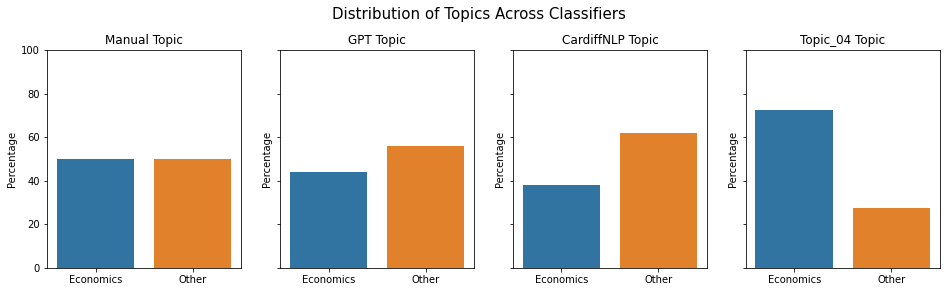

In [6]:
fig, axes = plt.subplots(1, 4, figsize=(16, 4), sharey=True)
order = ['Economics', 'Other']

for idx, topic in enumerate(['Manual Topic', 'GPT Topic', 'CardiffNLP Topic', 'Topic_04 Topic']):
    value_counts = df[topic].value_counts(normalize=True).loc[order] * 100
    sns.barplot(ax=axes[idx], x=value_counts.index, y=value_counts, order=order)
    axes[idx].set_title(topic)
    axes[idx].set_ylabel('Percentage')
    axes[idx].set_ylim(0, 100)

plt.suptitle("Distribution of Topics Across Classifiers", fontsize=15, y=1.03)
plt.show()

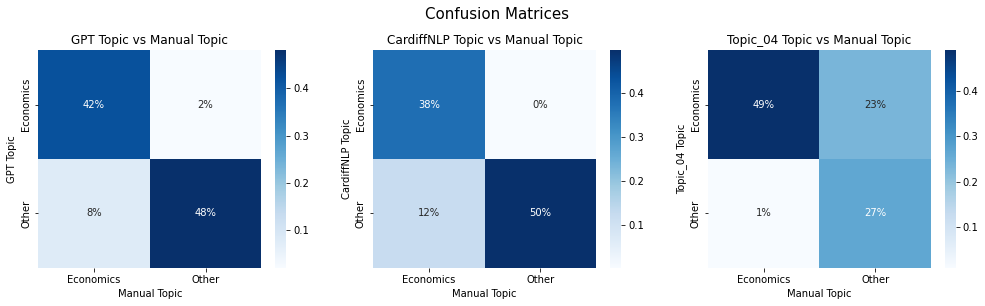

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(17, 4))

conf_mat = pd.crosstab(df['GPT Topic'], df['Manual Topic'])
sns.heatmap(conf_mat / conf_mat.sum().sum(), ax=axes[0], annot=True, fmt='.0%', cmap='Blues')
axes[0].set_title('GPT Topic vs Manual Topic')

conf_mat = pd.crosstab(df['CardiffNLP Topic'], df['Manual Topic'])
sns.heatmap(conf_mat / conf_mat.sum().sum(), ax=axes[1], annot=True, fmt='.0%', cmap='Blues')
axes[1].set_title('CardiffNLP Topic vs Manual Topic')

conf_mat = pd.crosstab(df['Topic_04 Topic'], df['Manual Topic'])
sns.heatmap(conf_mat / conf_mat.sum().sum(), ax=axes[2], annot=True, fmt='.0%', cmap='Blues')
axes[2].set_title('Topic_04 Topic vs Manual Topic')

plt.suptitle("Confusion Matrices", fontsize=15, y=1.03)
plt.show()

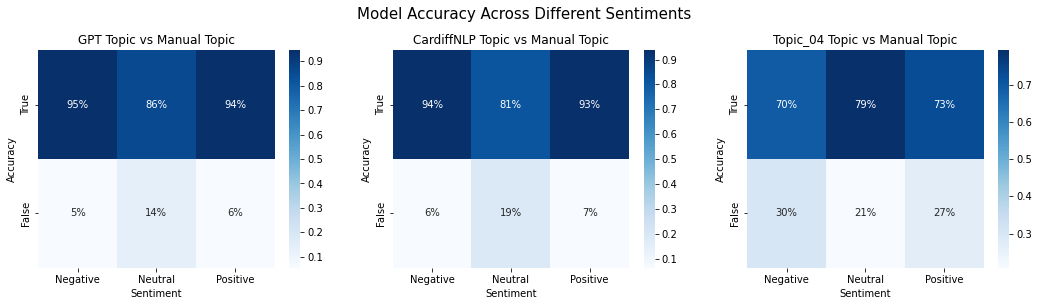

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

def plot_sentiment_accuracy_heatmap(df, model_col, label_col, sentiment_col, ax):
    df = df.copy()
    df = df[[model_col, label_col, sentiment_col]]
    df['Accuracy'] = df[model_col] == df[label_col]
    conf_mat = pd.crosstab(df['Accuracy'], df[sentiment_col], normalize='columns')
    conf_mat = conf_mat.reindex([True, False]) 
    sns.heatmap(conf_mat, ax=ax, annot=True, fmt='.0%', cmap='Blues')
    ax.set_title(f'{model_col} vs {label_col}')

plot_sentiment_accuracy_heatmap(df, 'GPT Topic', 'Manual Topic', 'Sentiment', axes[0])
plot_sentiment_accuracy_heatmap(df, 'CardiffNLP Topic', 'Manual Topic', 'Sentiment', axes[1])
plot_sentiment_accuracy_heatmap(df, 'Topic_04 Topic', 'Manual Topic', 'Sentiment', axes[2])

plt.suptitle("Model Accuracy Across Different Sentiments", fontsize=15, y=1.03)
plt.show()

Accuracy of Combined model: 93.26%


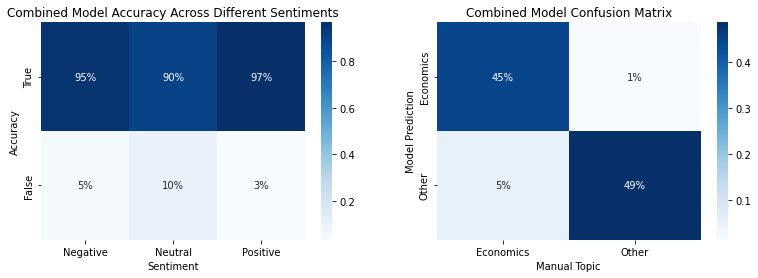

In [9]:
df['Topic'] = df[['GPT Topic', 'CardiffNLP Topic', 'Topic_04 Topic']].mode(axis=1)[0]
print(f"Accuracy of Combined model: {np.mean(df['Manual Topic'] == df['Topic']):.2%}")

fig, axes = plt.subplots(1, 2, figsize=(13, 4))
plot_sentiment_accuracy_heatmap(df, 'Topic', 'Manual Topic', 'Sentiment', axes[0])
axes[0].set_title('Combined Model Accuracy Across Different Sentiments')

conf_mat = pd.crosstab(df['Topic'], df['Manual Topic'])
sns.heatmap(conf_mat / conf_mat.sum().sum(), ax=axes[1], annot=True, fmt='.0%', cmap='Blues')
axes[1].set_title('Combined Model Confusion Matrix')
axes[1].set_ylabel('Model Prediction')
plt.show()

In [10]:
eco_oth = df[(df['Manual Topic'] == 'Economics') & (df['Topic'] == 'Other')]
eco_oth = eco_oth['Headlines'].sample(7).values.tolist()
print('\033[1m' + 'Sentences w/ Human Label: Economics, Combined Model Prediction: Other' + '\033[0m')
for row in eco_oth:
    print(f'  "{row}"')
    
oth_eco = df[(df['Manual Topic'] == 'Other') & (df['Topic'] == 'Economics')]
oth_eco = oth_eco['Headlines'].sample(7).values.tolist()
print('\n\033[1m' + 'Sentences w/ Human Label: Other, Combined Model Prediction: Economics' + '\033[0m')
for row in oth_eco:
    print(f'  "{row}"')

Sentences w/ Human Label: Economics, Combined Model Prediction: Other
  "The fine print is here"
  "He confirmed his view on July 6"
  "Purchase it for the 12MP snapper, if nothing else"
  "ALEXANDRIA, Va., June 7 -- Michael G. Williams of Newbury Park, Calif., has developed a network device"
  "The platen edges in contact with the band are provided with a seal having a protrusion directed towards the middle area of the platen, and means are provided to exert and maintain a pressure in the volume defined by the platen, the band and the seal."
  "The copying, republication or redistribution of AFX News Content, including by framing or similar means, is expressly prohibited without the prior written consent of AFX News"
  "This beauty is an updated version of her chichi loop shade launched in 2001"

Sentences w/ Human Label: Other, Combined Model Prediction: Economics
  "GM Plans to Use Woods More Creatively"
  "Instant Analysis: Va Tech at Miami"
  "Report: Lehman to get Ryder Cup job"


### Findings

- Both GPT and CardiffNLP models tend to over-predict sentences as belonging to the `Other` category.
- In contrast, the Topic_04 model shows a higher tendency to classify sentences as `Economics`.
- The Topic_04 model has a lower overall accuracy (75%) compared to the other two models:
    - GPT model: 90% accuracy
    - CardiffNLP model: 88% accuracy
- GPT and CardiffNLP models exhibit the most difficulty when classifying sentences with a `Neutral` sentiment.
- By combining the models, the overall accuracy is improved to 93%.
    - The combined model struggles mostly with sentences with `Neutral` sentiment.
    - Looking at the confusion matrix, we can see that the model is more likely to misclassify sentences as `Economics` when their human label is `Other`.
- On manual inspection of sentences misclassified by the combined model, it is not clear which topic the sentence should belong to. 
    - In other words: The combined model struggles where a human would also struggle.

Overall, the combination of the models seems to be the best approach and seems to result in high quality labels.

## Test set

Now we'll look at the labelled data. First we'll start with the test set class distribution.

In [11]:
# Check test set classifications
test = pd.read_csv('../../data/fixed-data/topic-test.csv')

test.info()
test.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32798 entries, 0 to 32797
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Headlines  32798 non-null  object
 1   Topic      32798 non-null  object
dtypes: object(2)
memory usage: 512.6+ KB


,Headlines,Topic
count,32798,32798
unique,32798,2
top,black decker shares up on profit outlook,Other
freq,1,20552


In [12]:
print(test.tail(10)[['Headlines', 'Topic']])

                                               Headlines      Topic
32788  debenhams to rent flagship store space to hot ...  Economics
32789  will smith s production company reaches settle...      Other
32790              new mydoom draws on ie flaw to spread      Other
32791  huawei says u.s. sanctions have no immediate i...  Economics
32792                         formula for transformation      Other
32793  jackson browne and the eagles honor glenn frey...      Other
32794  uaw will not extend gm contract, but no decisi...  Economics
32795         10 facts you should know about outsourcing  Economics
32796   berkshire confirms buffett subpoenaed to testify  Economics
32797  new york looks to teens in effort to prevent d...      Other


In [13]:
# Class distribution
print(test.groupby('Topic')['Headlines'].count() / len(test))

Topic
Economics    0.373376
Other        0.626624
Name: Headlines, dtype: float64


## Train set

The test set distribution is slightly imbalanced. Let's see if the train set is also imbalanced.

In [14]:
train = pd.read_csv('../../data/fixed-data/topic-train.csv')
val = pd.read_csv('../../data/fixed-data/topic-val.csv')
train = pd.concat([train, val], ignore_index=True)
print(train.groupby('Topic')['Headlines'].count() / len(train))

Topic
Economics    0.372032
Other        0.627967
Name: Headlines, dtype: float64


We're working with a slightly imbalanced train dataset. 

Next, we'll take a depper dive into the train dataset to see if we can find any problems or patterns.

In [15]:
train.info()
train.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 817357 entries, 0 to 817356
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Headlines  817356 non-null  object
 1   Topic      817357 non-null  object
dtypes: object(2)
memory usage: 12.5+ MB


,Headlines,Topic
count,817356,817357
unique,817355,2
top,gatlin takes 100 meter gold,Other
freq,2,513274


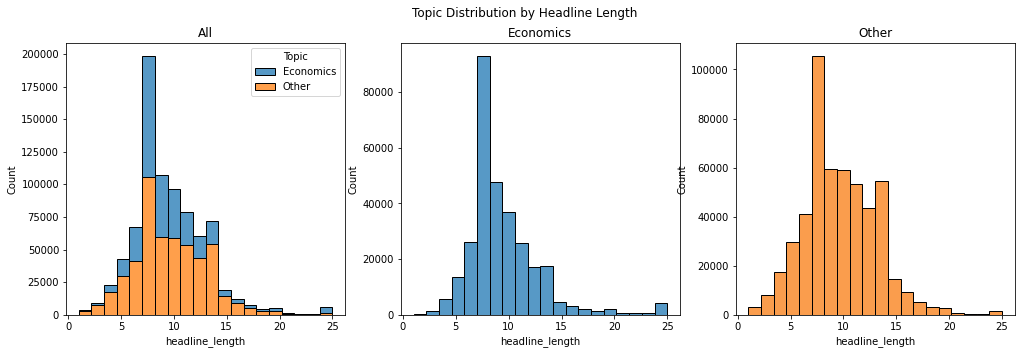

In [16]:
train['Headlines'] = train['Headlines'].astype(str)
train['headline_length'] = train['Headlines'].apply(lambda x: min(len(x.split()), 25))

fig, axes = plt.subplots(ncols=3, figsize=(17, 5))
sns.histplot(data=train, x='headline_length', hue='Topic', multiple='stack',
             bins=20, ax=axes[0])
economics = train[train['Topic'] == 'Economics']
other = train[train['Topic'] != 'Economics']

sns.histplot(data=economics, x='headline_length', multiple='stack',
             bins=20, ax=axes[1])
sns.histplot(data=other, x='headline_length', color='#f97d11', multiple='stack',
             bins=20, ax=axes[2])

fig.suptitle('Topic Distribution by Headline Length')
axes[0].set_title('All')
axes[1].set_title('Economics') 
axes[2].set_title('Other')
plt.show()

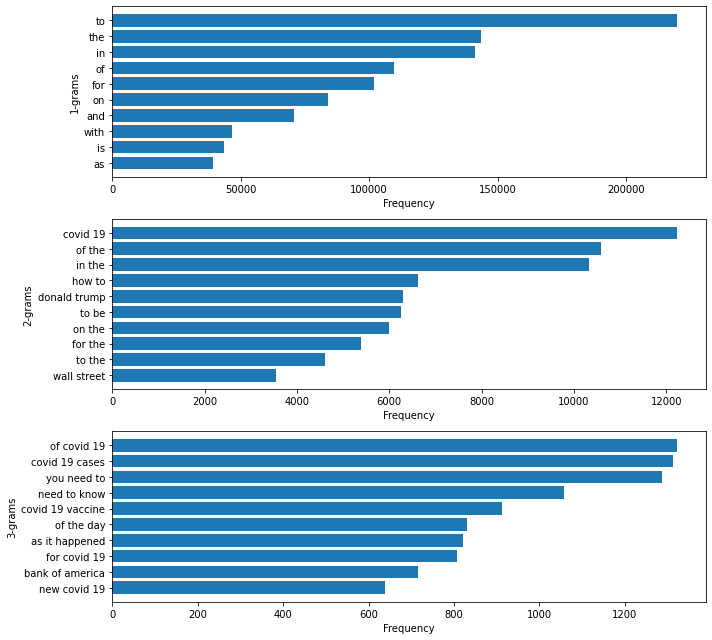

In [17]:
from sklearn.feature_extraction.text import CountVectorizer


def get_ngrams(corpus, ngrams=1, relative=False):
    """Get all n-grams from a corpus of text.
    
    Args:
        corpus: A list of strings representing the text documents.
        ngrams: The size of the n-grams to be extracted (default: 1).
        relative: If True, returns relative frequencies (default: False).
    
    Returns:
        A tuple containing two lists: n-gram words and their corresponding frequencies.
    """
    vec = CountVectorizer(ngram_range=(ngrams, ngrams)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    words, frequencies = zip(*words_freq)
    if relative:
        frequencies = frequencies / np.sum(frequencies)
    return words, frequencies


def plot_top_ngrams(ax, corpus, ngrams=1, top_k=10):
    """Plot the top k n-grams from a corpus of text."""
    words, frequencies = get_ngrams(corpus, ngrams=ngrams)
    words, frequencies = words[:top_k], frequencies[:top_k]
    ax.barh(words, frequencies)
    ax.invert_yaxis()
    ax.set_xlabel('Frequency')
    ax.set_ylabel(f'{ngrams}-grams')


fig, axes = plt.subplots(3, 1, figsize=(10, 9))
plot_top_ngrams(axes[0], train['Headlines'], ngrams=1)
plot_top_ngrams(axes[1], train['Headlines'], ngrams=2)
plot_top_ngrams(axes[2], train['Headlines'], ngrams=3)
plt.tight_layout()
plt.show()

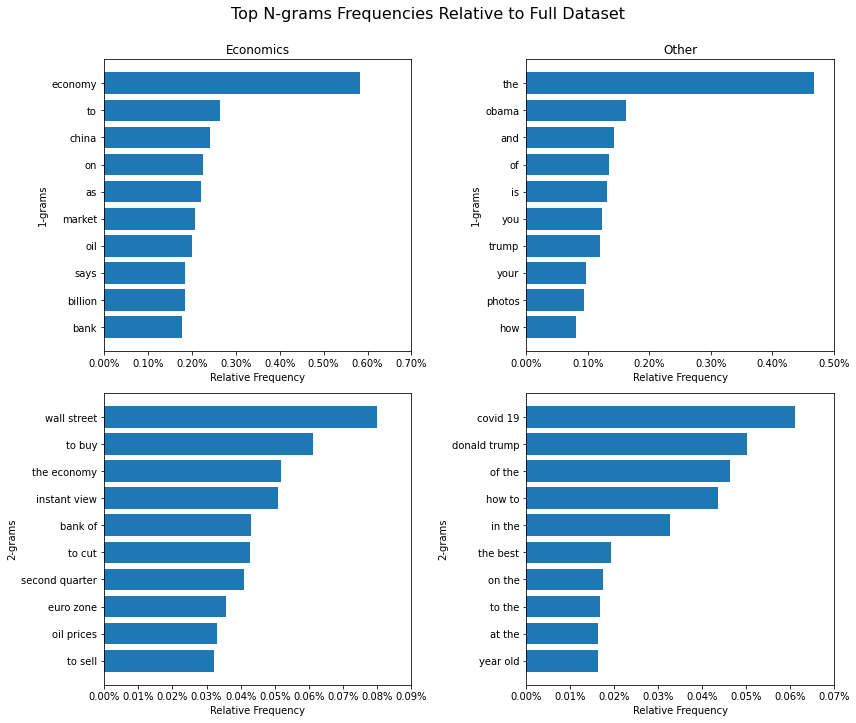

In [18]:
def plot_top_ngrams_relative(ax, corpus, total_counts, ngrams=1, top_k=10):
    """ Plot the top k n-grams relative to the total dataset for a given corpus.
    
    I.e. if 'bull' is 0.2% of the total dataset and 0.6% of the corpus, then the relative
    frequency of 'bull' is 0.6 - 0.2 = 0.4 %.
    
    Args:
        ax: A matplotlib axes object for plotting.
        corpus: A list of strings representing the text documents.
        total_counts: A dictionary containing the total counts of n-grams for all topics.
        ngrams: The size of the n-grams to be extracted (default: 1).
        top_k: The number of top n-grams to display (default: 10).
    """
    word_freq = get_ngrams(corpus, ngrams=ngrams, relative=True)
    relative_word_freq = [(w, f - total_counts[w]) for w, f in zip(*word_freq)]
    words_freq = sorted(relative_word_freq, key=lambda x: x[1], reverse=True)[:top_k]
    words, relative_frequencies = zip(*words_freq)

    ax.barh(words, relative_frequencies)
    ax.invert_yaxis()
    ax.set_xlabel('Relative Frequency')
    ax.set_ylabel(f'{ngrams}-grams')
    # Set x-axis to percentage
    xticks = ax.get_xticks()
    ax.set_xticks(xticks)
    ax.set_xticklabels(['{:,.2%}'.format(x) for x in xticks])


total_1ngrams = get_ngrams(train['Headlines'], ngrams=1, relative=True)
total_1ngrams = dict(zip(*total_1ngrams))
total_2ngrams = get_ngrams(train['Headlines'], ngrams=2, relative=True)
total_2ngrams = dict(zip(*total_2ngrams))

topics = ['Economics', 'Other']
num_topics = len(topics)
fig, axes = plt.subplots(2, num_topics, figsize=(6 * num_topics, 10))

for col, topic in enumerate(topics):
    headlines = train[train['Topic'] == topic]['Headlines']
    axes[0, col].set_title(topic)
    plot_top_ngrams_relative(axes[0, col], headlines, total_counts=total_1ngrams, ngrams=1)
    plot_top_ngrams_relative(axes[1, col], headlines, total_counts=total_2ngrams, ngrams=2)

fig.suptitle('Top N-grams Frequencies Relative to Full Dataset', fontsize=16, y=1.0)
plt.tight_layout()
plt.show()

## Key Findings

After analyzing the dataset, the following key findings have emerged:

- The dataset is now only slightly imbalanced, with 62% of headlines labelled `Other` and 38% labelled `Economics`.
    - Additionally class weighting is applied to the loss function to further reduce the impact of the imbalance.
- The sentence length distributions of the two topics are somewhat different, but this difference has significantly decreased compared to the previous dataset.

The latest change of making the dataset more balanced will hopefully improve the model's performance.

### Earlier Findings

<span style="color: #999999">*This section contains the findings from earlier versions of the dataset.*</span>

**v2**

After analyzing the dataset, the following key findings have emerged:
- The dataset is imbalanced, with `Other` having significantly more headlines than `Economics`. 
    - One potential solution is to optimize a loss function that takes this into account (I.e. Class weighting). 
    - Alternatively, the `Economics` headlines could be repeated until the dataset is balanced.
- While the frequency of `covid-19` n-grams is still high, it has decreased compared to the first version of the dataset.
- The sentence length distributions of the two topics are somewhat different, but this difference has significantly decreased compared to the previous dataset.

Overall, the quality of the dataset has improved compared to the previous iteration and is now suitable for training models.


**v1**
- The dataset is imbalanced.
    - Either optimize a loss function that takes this into account
    - Or repeat `Economics` headlines until the dataset is balanced.
- The amount of `covid-19` n-grams should be looked into. It means that the COVID-era headlines dominates dataset, which might not represent normal news coverage. 
- The two topics have a very different sentence length distributions. This might cause problems for the models.

Overall, the dataset quality should be improved before starting training models.
